In [ ]:
import pandas as pd 
import numpy as np 
import tensorflow 
from tensorflow import keras 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import GridSearchCV,train_test_split, learning_curve
from keras.wrappers.scikit_learn import KerasClassifier
import keras_tuner as kt
from sklearn.ensemble import RandomForestRegressor

In [ ]:
data = pd.read_csv("/content/Property.csv", delimiter=";", encoding = "utf-8")

In [ ]:
relevant_cols = ["property_type","price", "location", "city", "province_name", "baths", "area","purpose", "bedrooms"]
data = data[relevant_cols]

In [ ]:
#starting off with cleaning the data 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191393 entries, 0 to 191392
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   property_type  191393 non-null  object
 1   price          191393 non-null  int64 
 2   location       191393 non-null  object
 3   city           191393 non-null  object
 4   province_name  191393 non-null  object
 5   baths          191393 non-null  int64 
 6   area           191393 non-null  object
 7   purpose        191393 non-null  object
 8   bedrooms       191393 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 13.1+ MB


In [ ]:
data.describe()
#1. data cleaning - clean all columns and remove errors from the dataset
# starting off with converting size to sqm, as the measure of size is in Kanal and Marla
# 1 kanal = 505,857 sqm, 1 marla = 25,2929 sqm
# second - clean date to make it the same format 

,price,baths,bedrooms
count,1.913930e+05,191393.000000,191393.000000
mean,1.644655e+07,2.865956,3.171516
std,3.416412e+07,2.435332,1.952403
min,0.000000e+00,0.000000,0.000000
25%,8.000000e+04,0.000000,2.000000
50%,7.300000e+06,3.000000,3.000000
75%,1.800000e+07,4.000000,4.000000
max,2.000000e+09,403.000000,68.000000


In [ ]:
#checking out the different property types we have in the data 
pd.unique(data["property_type"])

array(['House', 'Flat', 'Lower Portion', 'Penthouse', 'Upper Portion',
       'Farm House', 'Room'], dtype=object)

In [ ]:
#checking the different purposes. The relevant purpose for this project is only the real estate that is for sale. Therefore, those that are for rent will be filtered out
pd.unique(data["purpose"])

array(['For Sale', 'For Rent'], dtype=object)

In [ ]:
data = data[data["purpose"]=="For Sale"]
pd.unique(data["purpose"])
#the filtered dataset contains only the real estate that is for sale. 

array(['For Sale'], dtype=object)

In [ ]:
# from 191393  records to 127018 records because of the filtering

data

,property_type,price,location,city,province_name,baths,area,purpose,bedrooms
0,House,220000000,Model Town,Lahore,Punjab,0,6 Kanal,For Sale,0
1,House,40000000,Multan Road,Lahore,Punjab,5,1 Kanal,For Sale,5
2,House,9500000,Eden,Lahore,Punjab,0,9 Marla,For Sale,3
3,House,125000000,Gulberg,Lahore,Punjab,7,1 Kanal,For Sale,8
4,House,21000000,Allama Iqbal Town,Lahore,Punjab,5,11 Marla,For Sale,6
...,...,...,...,...,...,...,...,...,...
190971,House,3600000,DHA Defence,Islamabad,Islamabad Capital,2,5 Marla,For Sale,2
190972,House,17000000,G-13,Islamabad,Islamabad Capital,5,4 Marla,For Sale,4
190973,House,16800000,G-13,Islamabad,Islamabad Capital,5,4 Marla,For Sale,4
190974,House,26500000,G-13,Islamabad,Islamabad Capital,7,8 Marla,For Sale,5


In [ ]:
#now have to make new columns that give us the "area" column in squaremeters 
data['Marla'] = np.where(data['area'].str.contains("Marla"), data.area,0)
data['Kanal'] = np.where(data['area'].str.contains("Kanal"), data.area,0)

In [ ]:
data.head()


,property_type,price,location,city,province_name,baths,area,purpose,bedrooms,Marla,Kanal
0,House,220000000,Model Town,Lahore,Punjab,0,6 Kanal,For Sale,0,0,6 Kanal
1,House,40000000,Multan Road,Lahore,Punjab,5,1 Kanal,For Sale,5,0,1 Kanal
2,House,9500000,Eden,Lahore,Punjab,0,9 Marla,For Sale,3,9 Marla,0
3,House,125000000,Gulberg,Lahore,Punjab,7,1 Kanal,For Sale,8,0,1 Kanal
4,House,21000000,Allama Iqbal Town,Lahore,Punjab,5,11 Marla,For Sale,6,11 Marla,0


In [ ]:
data["Marla"] = data.Marla.str.replace("Marla", "")
data["Kanal"] = data.Kanal.str.replace("Kanal", "")
data.head()

,property_type,price,location,city,province_name,baths,area,purpose,bedrooms,Marla,Kanal
0,House,220000000,Model Town,Lahore,Punjab,0,6 Kanal,For Sale,0,NaN,6
1,House,40000000,Multan Road,Lahore,Punjab,5,1 Kanal,For Sale,5,NaN,1
2,House,9500000,Eden,Lahore,Punjab,0,9 Marla,For Sale,3,9,NaN
3,House,125000000,Gulberg,Lahore,Punjab,7,1 Kanal,For Sale,8,NaN,1
4,House,21000000,Allama Iqbal Town,Lahore,Punjab,5,11 Marla,For Sale,6,11,NaN


In [ ]:
data.dtypes





property_type    object
price             int64
location         object
city             object
province_name    object
baths             int64
area             object
purpose          object
bedrooms          int64
Marla            object
Kanal            object
dtype: object

In [ ]:
data.Marla=data.Marla.fillna(0)
data.Kanal = data.Kanal.fillna(0)

data.Marla = data["Marla"].astype(str)
data.Kanal = data["Kanal"].astype(str)


In [ ]:
data.Marla = data.Marla.str.replace(",",".")
data.Kanal = data.Kanal.str.replace(",",".")


In [ ]:
data.Marla = data["Marla"].astype(str).astype(float)
#data.Kanal = data["Kanal"].astype(str).astype(float)
#ValueError: could not convert string to float: '1.722.2 '

In [ ]:
data.dtypes

property_type     object
price              int64
location          object
city              object
province_name     object
baths              int64
area              object
purpose           object
bedrooms           int64
Marla            float64
Kanal             object
dtype: object

In [ ]:
#data.Kanal = data.Kanal.astype(float)
#ValueError: could not convert string to float: '1.722.2 '

In [ ]:
data.Kanal = data.Kanal.str.replace(".","")


In [ ]:
data.Kanal = data.Kanal.astype(float)

In [ ]:
data.head()

,property_type,price,location,city,province_name,baths,area,purpose,bedrooms,Marla,Kanal
0,House,220000000,Model Town,Lahore,Punjab,0,6 Kanal,For Sale,0,0.0,6.0
1,House,40000000,Multan Road,Lahore,Punjab,5,1 Kanal,For Sale,5,0.0,1.0
2,House,9500000,Eden,Lahore,Punjab,0,9 Marla,For Sale,3,9.0,0.0
3,House,125000000,Gulberg,Lahore,Punjab,7,1 Kanal,For Sale,8,0.0,1.0
4,House,21000000,Allama Iqbal Town,Lahore,Punjab,5,11 Marla,For Sale,6,11.0,0.0


In [ ]:
 #1 kanal = 505,857 sqm, 1 marla = 25,2929 sqm
kanal = 505.857
marla = 25.2929


data["sqm_marla"] = data.Marla*marla
data["sqm_kanal"] = data.Kanal*kanal
data["sqm"] = data.sqm_marla + data.sqm_kanal


In [ ]:
data.head()

,property_type,price,location,city,province_name,baths,area,purpose,bedrooms,Marla,Kanal,sqm_marla,sqm_kanal,sqm
0,House,220000000,Model Town,Lahore,Punjab,0,6 Kanal,For Sale,0,0.0,6.0,0.0000,3035.142,3035.1420
1,House,40000000,Multan Road,Lahore,Punjab,5,1 Kanal,For Sale,5,0.0,1.0,0.0000,505.857,505.8570
2,House,9500000,Eden,Lahore,Punjab,0,9 Marla,For Sale,3,9.0,0.0,227.6361,0.000,227.6361
3,House,125000000,Gulberg,Lahore,Punjab,7,1 Kanal,For Sale,8,0.0,1.0,0.0000,505.857,505.8570
4,House,21000000,Allama Iqbal Town,Lahore,Punjab,5,11 Marla,For Sale,6,11.0,0.0,278.2219,0.000,278.2219


In [ ]:
data = data.drop(columns={"Marla", "Kanal", "area", "sqm_marla", "sqm_kanal"})

In [ ]:
data.head()

,property_type,price,location,city,province_name,baths,purpose,bedrooms,sqm
0,House,220000000,Model Town,Lahore,Punjab,0,For Sale,0,3035.1420
1,House,40000000,Multan Road,Lahore,Punjab,5,For Sale,5,505.8570
2,House,9500000,Eden,Lahore,Punjab,0,For Sale,3,227.6361
3,House,125000000,Gulberg,Lahore,Punjab,7,For Sale,8,505.8570
4,House,21000000,Allama Iqbal Town,Lahore,Punjab,5,For Sale,6,278.2219


In [ ]:
data.isna().sum() #no nulls 

property_type    0
price            0
location         0
city             0
province_name    0
baths            0
purpose          0
bedrooms         0
sqm              0
dtype: int64

In [ ]:
data = data.drop("purpose", axis = "columns")

In [ ]:
data["sqm_price"] = data["price"]/data["sqm"]

In [ ]:
price_outliers = data[['price']]
baths_outliers = data[["baths"]]
bedrooms_outliers = data[["bedrooms"]]
sqm_outliers = data[["sqm"]]
sqm_price_outliers = data[["sqm_price"]]

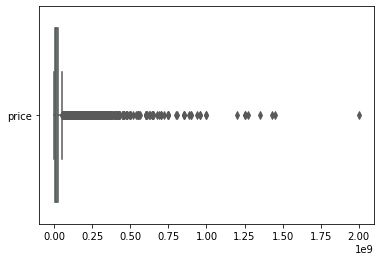

In [ ]:
ax = sns.boxplot(data=price_outliers, orient="h", palette="Set2")

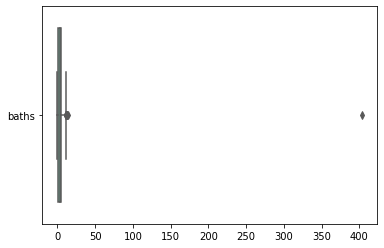

In [ ]:
ax = sns.boxplot(data=baths_outliers, orient="h", palette="Set2")

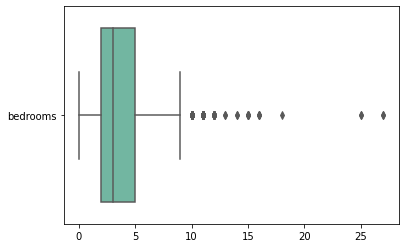

In [ ]:
ax = sns.boxplot(data=bedrooms_outliers, orient="h", palette="Set2")


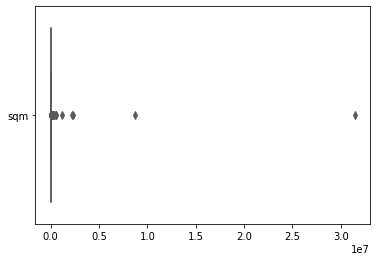

In [ ]:
ax = sns.boxplot(data=sqm_outliers, orient="h", palette="Set2")

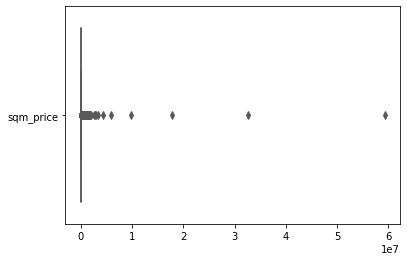

In [ ]:
ax = sns.boxplot(data=sqm_price_outliers, orient="h", palette="Set2")

In [ ]:
#removing the outliers

cols = ["price", "baths", "bedrooms", "sqm", "sqm_price"]
Q1 = data[cols].quantile(0.25)
Q3 = data[cols].quantile(0.75)
IQR = Q3-Q1

data = data[~((data[cols] < (Q1 - 1.5 * IQR)) |(data[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [ ]:
price_outliers = data[['price']]
baths_outliers = data[["baths"]]
bedrooms_outliers = data[["bedrooms"]]
sqm_outliers = data[["sqm"]]
sqm_price_outliers = data[["sqm_price"]]

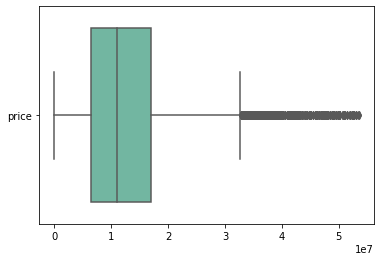

In [ ]:
ax = sns.boxplot(data=price_outliers, orient="h", palette="Set2")

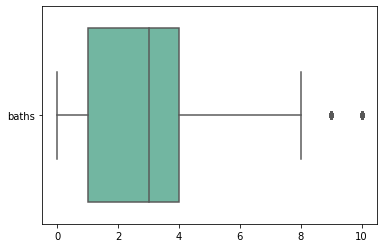

In [ ]:
ax = sns.boxplot(data=baths_outliers, orient="h", palette="Set2")


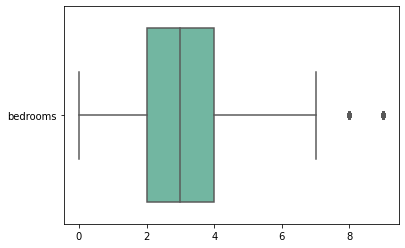

In [ ]:
ax = sns.boxplot(data=bedrooms_outliers, orient="h", palette="Set2")


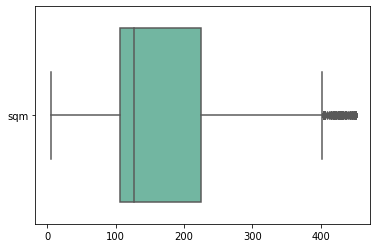

In [ ]:
ax = sns.boxplot(data=sqm_outliers, orient="h", palette="Set2")


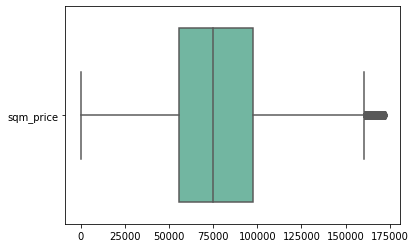

In [ ]:
ax = sns.boxplot(data=sqm_price_outliers, orient="h", palette="Set2")

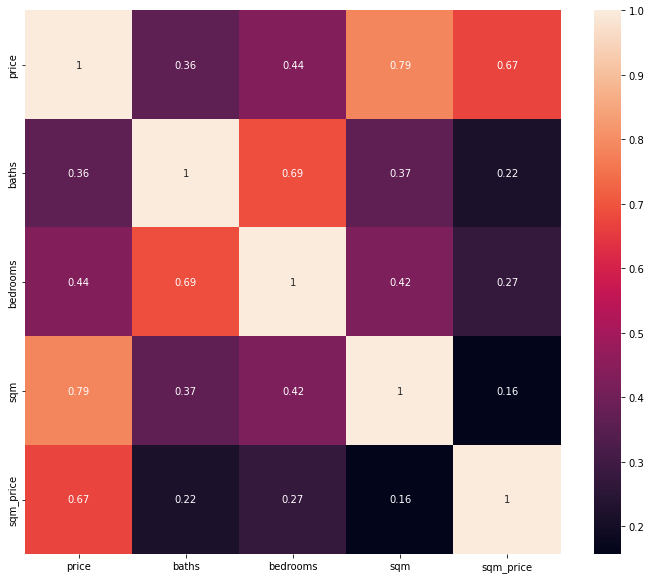

In [ ]:
corr = data.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True)
plt.show()

In [ ]:
#data.location = data.location.str.lower()
data.city = data.city.str.lower()

In [ ]:
#will process only with city 
#dummies_location = pd.get_dummies(data.location)
#dummies_location
dummies_city = pd.get_dummies(data.city)
dummies_city

,faisalabad,islamabad,karachi,lahore,rawalpindi
2,0,0,0,1,0
4,0,0,0,1,0
6,0,0,0,1,0
10,0,0,0,1,0
12,0,0,0,1,0
...,...,...,...,...,...
190971,0,1,0,0,0
190972,0,1,0,0,0
190973,0,1,0,0,0
190974,0,1,0,0,0


In [ ]:
#data = pd.concat([data,dummies_location],axis="columns")
#data.head()
data = pd.concat([data,dummies_city], axis = "columns")
data.property_type = data.property_type.str.lower()
dummies2 = pd.get_dummies(data.property_type)
data = pd.concat([data,dummies2], axis="columns")

In [ ]:
data = data.drop(columns={"city","location", "property_type","sqm_price","province_name"}, axis = "columns")

data



,price,baths,bedrooms,sqm,faisalabad,islamabad,karachi,lahore,rawalpindi,farm house,flat,house,lower portion,penthouse,room,upper portion
2,9500000,0,3,227.63610,0,0,0,1,0,0,0,1,0,0,0,0
4,21000000,5,6,278.22190,0,0,0,1,0,0,0,1,0,0,0,0
6,16500000,7,6,202.34320,0,0,0,1,0,0,0,1,0,0,0,0
10,13500000,4,4,189.69675,0,0,0,1,0,0,0,1,0,0,0,0
12,8500000,4,4,126.46450,0,0,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190971,3600000,2,2,126.46450,0,1,0,0,0,0,0,1,0,0,0,0
190972,17000000,5,4,101.17160,0,1,0,0,0,0,0,1,0,0,0,0
190973,16800000,5,4,101.17160,0,1,0,0,0,0,0,1,0,0,0,0
190974,26500000,7,5,202.34320,0,1,0,0,0,0,0,1,0,0,0,0


In [ ]:
#data is cleaned now splitting the data and starting to build the models
X= data.drop(columns=["price"])
y=data[["price"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [ ]:
X_train.shape #(81226, 15)
y_train.shape #(81226, 1)

(81226, 1)

In [ ]:
test_data= np.array([0,	3,	227.63610,	0,	0,	0,	1,	0,	0,	0,	1,	0,	0,	0,	0])
print(model.predict(test_data.reshape(1,15), batch_size =1))

[[18546304.]]


In [ ]:
#random forest regressor

rf = RandomForestRegressor(n_estimators=250, random_state = 5) #trying out some random values 
rf.fit(X_train, np.ravel(y_train))
y_pred_rf = rf.predict(X_test)
print(rf.score(X_test, y_test))


0.7543354677531465


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


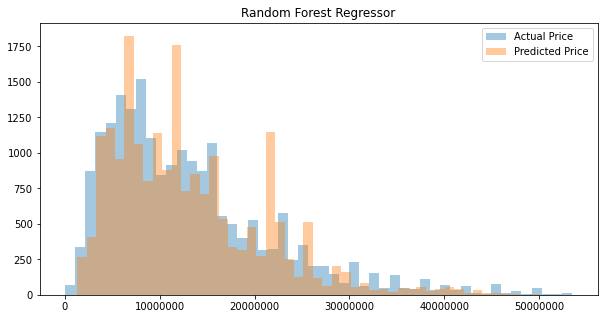

In [ ]:
#plotting actual price vs predicted price
plt.figure(figsize=(10,5))
sns.distplot(y_test, hist=True, kde=False)
sns.distplot(y_pred_rf, hist= True, kde= False)
plt.legend(labels=["Actual Price", "Predicted Price"])
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
plt.title("Random Forest Regressor")
plt.show()

In [ ]:
param_grid = {
    "n_estimators": [175,225,250,275,300,350,400]
}


clf = GridSearchCV(estimator=RandomForestRegressor(), param_grid = param_grid, cv=5)
clf.fit(X_train, np.ravel(y_train))

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [175, 225, 250, 275]})

In [ ]:
clf.best_params_ 

{'n_estimators': 275}

In [ ]:
def build_model(optimizer): 
  model = keras.Sequential()
  model.add(keras.layers.Dense(15,activation="relu", input_shape=(15,)))
  model.add(keras.layers.Dense(15,activation="relu"))
  model.add(keras.layers.Dense(1))

  model.compile(optimizer = optimizer, loss="mean_squared_error")

  return model 

In [ ]:
model = build_model("adam")

In [ ]:
model.fit(X,y,epochs=30)

Epoch 1/30
3173/3173 [==============================] - 7s 2ms/step - loss: 247548627386368.0000
Epoch 2/30
3173/3173 [==============================] - 5s 2ms/step - loss: 217241677201408.0000
Epoch 3/30
3173/3173 [==============================] - 5s 2ms/step - loss: 152191025283072.0000
Epoch 4/30
3173/3173 [==============================] - 5s 2ms/step - loss: 77711947071488.0000
Epoch 5/30
3173/3173 [==============================] - 5s 2ms/step - loss: 36069517033472.0000
Epoch 6/30
3173/3173 [==============================] - 5s 2ms/step - loss: 30802161172480.0000
Epoch 7/30
3173/3173 [==============================] - 5s 2ms/step - loss: 30755465986048.0000
Epoch 8/30
3173/3173 [==============================] - 5s 2ms/step - loss: 30728456765440.0000
Epoch 9/30
3173/3173 [==============================] - 5s 2ms/step - loss: 30706902237184.0000
Epoch 10/30
3173/3173 [==============================] - 5s 2ms/step - loss: 30683017773056.0000
Epoch 11/30
3173/3173 [=============